In [12]:
import numpy as np
import pandas as pd
import spacy 
nlp = spacy.load('en_core', parse=True, tag=True, entity=True)
import re
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
import unicodedata
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [46]:
rspct_df = pd.read_csv('reddit-selfposts/rspct.tsv', sep='\t')
info_df  = pd.read_csv('reddit-selfposts/subreddit_info.csv')
rspct_df.head()

,id,subreddit,title,selftext
0,6d8knd,talesfromtechsupport,Remember your command line switches...,"Hi there, <lb>The usual. Long time lerker, fi..."
1,58mbft,teenmom,"So what was Matt ""addicted"" to?",Did he ever say what his addiction was or is h...
2,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. T...
3,6ti6re,ringdoorbell,"Not door bell, but floodlight mount height.",I know this is a sub for the 'Ring Doorbell' b...
4,77sxto,intel,Worried about my 8700k small fft/data stress r...,"Prime95 (regardless of version) and OCCT both,..."


In [47]:
# note that info_df has information on subreddits that are not in data, 
# we filter them out here
info_df = info_df[info_df.in_data]
info_df = info_df.sample(n=10, random_state=1)
print(info_df)

            subreddit   category_1         category_2 category_3  in_data  \
2842        everquest   video_game          everquest        NaN     True   
1848    psychotherapy   profession            therapy        NaN     True   
886   ShieldAndroidTV  electronics         television  shield tv     True   
1560  twentyonepilots        music  twenty one pilots        NaN     True   
3232          teslore   video_game  the elder scrolls        NaN     True   
739             gopro  electronics             camera      gopro     True   
2179     uBlockOrigin     software  content filtering    u block     True   
2825    dwarffortress   video_game     dwarf fortress        NaN     True   
1034         HongKong          geo          hong kong    country     True   
99            araragi  anime/manga         monogatari        NaN     True   

     reason_for_exclusion  
2842                  NaN  
1848                  NaN  
886                   NaN  
1560                  NaN  
3232        

In [65]:
info_df.subreddit.unique()

array(['everquest', 'psychotherapy', 'ShieldAndroidTV', 'twentyonepilots',
       'teslore', 'gopro', 'uBlockOrigin', 'dwarffortress', 'HongKong',
       'araragi'], dtype=object)

In [48]:
#Text pre-processing
def text_preprocess(text):
    #remove chinese character
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    #remove numbers
    text = re.sub('\d+', '', text)
    text = re.sub('_', '', text)
    text = re.sub('\s+', ' ', text)
    #remove html links
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',text)
    #replace special characters with ''
    text = re.sub('[^\w\s]', '', text)
    #remove extra whitespaces
    text = text.strip()
    #text = text.lower()
    #remove accented characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

#remove stop words
def remove_stopwords(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    text = [token for token in tokens if token.lower() not in stopword_list]
    return " ".join(text)

#lemmatize text
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [49]:
def normalize_corpus(corpus):
    
    normalized_corpus = []
    for doc in corpus:
        # remove special character and normalize docs
        doc = text_preprocess(doc)
        # remove stopwords 
        #doc = remove_stopwords(doc)
        # lemmatize docs    
        doc = lemmatize_text(doc)
        normalized_corpus.append(doc)    
    return normalized_corpus

In [77]:
# Function to plot confusion matrix
# reference: https://datascience.stackexchange.com/questions/40067/confusion-matrix-three-classes-python
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [50]:
#train, test split. The dataset is already ordered in a way that the last 20% data is reserved for stratafied test dataset
train_split_index = int(len(rspct_df) * 0.8)
train_df, test_df = rspct_df[:train_split_index], rspct_df[train_split_index:]

In [51]:
#Taking only a sample of 10 subreddits for Train and Test sets - sub sampling
train_df_sample = train_df[train_df['subreddit'].isin(info_df['subreddit'])]
test_df_sample = test_df[test_df['subreddit'].isin(info_df['subreddit'])]

In [52]:
# Concatenating comment title and body in order to process them together
train_df_posts = pd.DataFrame(columns = ['posts','subreddit'])
test_df_posts = pd.DataFrame(columns = ['posts','subreddit'])

train_df_posts['posts']= train_df_sample['title']+ " "+ train_df_sample['selftext']
train_df_posts['subreddit'] = train_df_sample['subreddit']

test_df_posts['posts']= test_df_sample['title']+ " "+ test_df_sample['selftext']
test_df_posts['subreddit'] = test_df_sample['subreddit']

train_df_posts.head()

,posts,subreddit
794,How secure is the Lore about the towers? First...,teslore
801,ERROR - handle_stream_read error 335544539 sho...,ShieldAndroidTV
813,Should you REALLY watch Monogatari in the broa...,araragi
1064,"PhD in Counselor Education and Supervision Hi,...",psychotherapy
1068,What cover art by Vofan would you like to see ...,araragi


In [53]:
X_train , X_test  = train_df_posts.posts, test_df_posts.posts
y_train, y_test   = train_df_posts.subreddit, test_df_posts.subreddit

X_train_normalized = normalize_corpus(X_train)
X_test_normalized = normalize_corpus(X_test)

In [54]:
# Encode the subreddit lables.
# label encode y
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test  = le.transform(y_test)

y_train[:5]

array([7, 1, 2, 6, 2])

In [72]:
integer_mapping = {l: i for i, l in enumerate(le.classes_)}
print(integer_mapping)

{'HongKong': 0, 'ShieldAndroidTV': 1, 'araragi': 2, 'dwarffortress': 3, 'everquest': 4, 'gopro': 5, 'psychotherapy': 6, 'teslore': 7, 'twentyonepilots': 8, 'uBlockOrigin': 9}


In [55]:
# instatiating the TfidfVectorizer
tfidvec = TfidfVectorizer(max_features = 3000,
                                min_df=5,
                                ngram_range=(1,2),
                                stop_words=stopword_list,
                                analyzer='word',
                                token_pattern='(?u)\\b\\w+\\b')

# getting the sparse matrices for X_train and X_test
tfidvec.fit(X_train_normalized)
X_train_tfidf = tfidvec.transform(X_train_normalized)
X_test_tfidf = tfidvec.transform(X_test_normalized)

In [56]:
# Scaling the sparse matrix
transformer = MaxAbsScaler().fit(X_train_tfidf)
X_train_tfidf = transformer.transform(X_train_tfidf)
X_test_tfidf =  transformer.transform(X_test_tfidf)

In [58]:
#Naive Bayes with Tfidf
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB(alpha=0.1)
model.fit(X_train_tfidf,y_train)
result_model=model.predict(X_test_tfidf)
print("Accuracy Score:",accuracy_score(y_test,result_model))

Accuracy Score: 0.953


Confusion matrix, without normalization
[[173   3   3   3   1   4   8   0   4   1]
 [  1 198   0   0   1   0   0   0   0   0]
 [  5   1 186   0   1   0   0   0   5   2]
 [  1   1   3 190   2   0   0   0   1   2]
 [  1   2   0   1 193   1   1   0   1   0]
 [  1   4   0   0   1 193   0   0   0   1]
 [  4   1   0   0   1   0 192   0   2   0]
 [  1   1   1   4   1   0   0 192   0   0]
 [  2   1   1   0   1   3   1   0 191   0]
 [  1   0   0   0   0   0   0   0   1 198]]


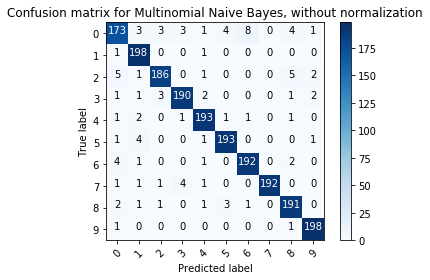

In [78]:
cnf_matrix_nb = confusion_matrix(y_test, result_model, labels=[0,1,2,3,4,5,6,7,8,9])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_nb, classes=[0,1,2,3,4,5,6,7,8,9],
                      title='Confusion matrix for Multinomial Naive Bayes, without normalization')

In [59]:
#SVM with tfidf
clf = SVC(kernel='rbf')
clf.fit(X_train_tfidf,y_train)
result_clf=clf.predict(X_test_tfidf)
print("Accuracy Score:",accuracy_score(y_test,result_clf))

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.7475


Confusion matrix, without normalization
[[ 72   1   0   1   1   0  16 107   2   0]
 [  0 159   0   0   0   0   0  40   1   0]
 [  0   1 157   0   0   0   0  39   3   0]
 [  0   0   1 138   1   0   0  60   0   0]
 [  0   0   0   0 144   0   0  55   1   0]
 [  0   0   0   1   0 137   0  62   0   0]
 [  0   0   0   0   0   0 162  38   0   0]
 [  0   0   0   0   0   0   0 200   0   0]
 [  0   0   0   1   0   0   0  46 153   0]
 [  0   0   1   0   0   0   0  26   0 173]]


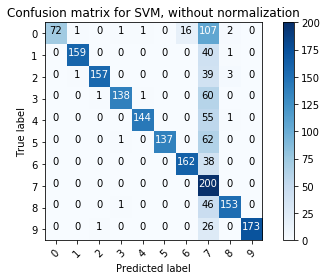

In [81]:
cnf_matrix_svm = confusion_matrix(y_test, result_clf, labels=[0,1,2,3,4,5,6,7,8,9])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_svm, classes=[0,1,2,3,4,5,6,7,8,9],
                      title='Confusion matrix for SVM, without normalization')

In [61]:
# Random Forest Classifier with Grid Search for parameter optimization
steps = [
    ("vectorizer", TfidfVectorizer(min_df=5,
                                   stop_words=stopword_list,
                                   analyzer='word',
                                   token_pattern='(?u)\\b\\w+\\b')),
    ("Scaler", MaxAbsScaler()),
    ("rf", RandomForestClassifier())
]

# instatiating the pipeline
pipe = Pipeline(steps)

# setting the values for the RandomForest model
grid_params = {
    "vectorizer__max_features": [2000, 3000, 4000],
    "vectorizer__ngram_range":[(1,1), (1,2)],
    "rf__n_estimators": [2500, 3000, 3500],
    "rf__max_depth": [17, 18, 19, 20],
    "rf__min_samples_leaf": [1, 2, 3]
    
}

# grid search
gs = GridSearchCV(pipe, grid_params, CV = 3, verbose=1, n_jobs=2)
results2 = gs.fit(X_train_normalized, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 13.0min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed: 52.3min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed: 133.7min
[Parallel(n_jobs=2)]: Done 648 out of 648 | elapsed: 236.8min finished


In [63]:
print(results2.score(X_test_normalized, y_test))

0.93


In [64]:
print(results2.best_params_)

{'rf__max_depth': 20, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 2500, 'vectorizer__max_features': 4000, 'vectorizer__ngram_range': (1, 1)}


Confusion matrix, without normalization
[[166   2   1   0   4   1   4  17   2   3]
 [  1 194   0   0   2   2   0   1   0   0]
 [  0   2 188   0   3   0   0   3   2   2]
 [  0   1   2 167   6   0   2  21   0   1]
 [  0   0   1   1 188   1   1   6   0   2]
 [  0   3   1   0   0 193   0   3   0   0]
 [  0   0   0   0   1   0 196   3   0   0]
 [  0   0   0   2   2   3   0 188   2   3]
 [  0   0   1   0   1   1   1  12 184   0]
 [  0   0   0   0   0   1   0   3   0 196]]


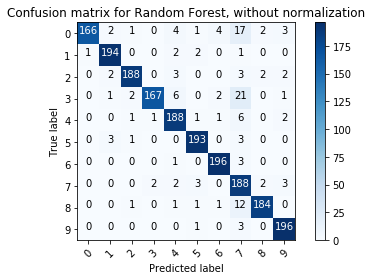

In [83]:
results_rf = gs.best_estimator_.predict(X_test_normalized)
cnf_matrix_rf = confusion_matrix(y_test, results_rf, labels=[0,1,2,3,4,5,6,7,8,9])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_rf, classes=[0,1,2,3,4,5,6,7,8,9],
                      title='Confusion matrix for Random Forest, without normalization')